In [ ]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
os.listdir('../input')

['hmnist_8_8_RGB.csv',
 'hmnist_28_28_RGB.csv',
 'HAM10000_images_part_1',
 'ham10000_images_part_1',
 'hmnist_8_8_L.csv',
 'HAM10000_images_part_2',
 'ham10000_images_part_2',
 'hmnist_28_28_L.csv',
 'HAM10000_metadata.csv']

In [3]:

base_dir = 'base_dir'
os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train_dir')
os.mkdir(train_dir)

val_dir = os.path.join(base_dir, 'val_dir')
os.mkdir(val_dir)

nv = os.path.join(train_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(train_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(train_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(train_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(train_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(train_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(train_dir, 'df')
os.mkdir(df)

nv = os.path.join(val_dir, 'nv')
os.mkdir(nv)
mel = os.path.join(val_dir, 'mel')
os.mkdir(mel)
bkl = os.path.join(val_dir, 'bkl')
os.mkdir(bkl)
bcc = os.path.join(val_dir, 'bcc')
os.mkdir(bcc)
akiec = os.path.join(val_dir, 'akiec')
os.mkdir(akiec)
vasc = os.path.join(val_dir, 'vasc')
os.mkdir(vasc)
df = os.path.join(val_dir, 'df')
os.mkdir(df)



### Create Train and Val Sets

In [4]:
df_data = pd.read_csv('../input/HAM10000_metadata.csv')

df_data.head()

lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear

### Create a stratified val set

In [5]:

df = df_data.groupby('lesion_id').count()

df = df[df['image_id'] == 1]

df.reset_index(inplace=True)

df.head()

lesion_id  image_id  dx  dx_type  age  sex  localization
0  HAM_0000001         1   1        1    1    1             1
1  HAM_0000003         1   1        1    1    1             1
2  HAM_0000004         1   1        1    1    1             1
3  HAM_0000007         1   1        1    1    1             1
4  HAM_0000008         1   1        1    1    1             1

In [6]:

def identify_duplicates(x):
    
    unique_list = list(df['lesion_id'])
    
    if x in unique_list:
        return 'no_duplicates'
    else:
        return 'has_duplicates'
    
df_data['duplicates'] = df_data['lesion_id']
df_data['duplicates'] = df_data['duplicates'].apply(identify_duplicates)

df_data.head()

lesion_id      image_id       ...       localization      duplicates
0  HAM_0000118  ISIC_0027419       ...              scalp  has_duplicates
1  HAM_0000118  ISIC_0025030       ...              scalp  has_duplicates
2  HAM_0002730  ISIC_0026769       ...              scalp  has_duplicates
3  HAM_0002730  ISIC_0025661       ...              scalp  has_duplicates
4  HAM_0001466  ISIC_0031633       ...                ear  has_duplicates

[5 rows x 8 columns]

In [7]:
df_data['duplicates'].value_counts()

no_duplicates     5514
has_duplicates    4501
Name: duplicates, dtype: int64

In [8]:
df = df_data[df_data['duplicates'] == 'no_duplicates']

df.shape

(5514, 8)

In [9]:
y = df['dx']

_, df_val = train_test_split(df, test_size=0.17, random_state=101, stratify=y)

df_val.shape

(938, 8)

In [10]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

### Create a train set that excludes images that are in the val set

In [11]:

def identify_val_rows(x):
    val_list = list(df_val['image_id'])
    
    if str(x) in val_list:
        return 'val'
    else:
        return 'train'


df_data['train_or_val'] = df_data['image_id']
df_data['train_or_val'] = df_data['train_or_val'].apply(identify_val_rows)
   
df_train = df_data[df_data['train_or_val'] == 'train']


print(len(df_train))
print(len(df_val))

9077
938


In [12]:
df_train['dx'].value_counts()

nv       5954
mel      1074
bkl      1024
bcc       484
akiec     301
vasc      131
df        109
Name: dx, dtype: int64

In [13]:
df_val['dx'].value_counts()

nv       751
bkl       75
mel       39
bcc       30
akiec     26
vasc      11
df         6
Name: dx, dtype: int64

### Transfer the Images into the Folders

In [14]:
df_data.set_index('image_id', inplace=True)

In [15]:
folder_1 = os.listdir('../input/ham10000_images_part_1')
folder_2 = os.listdir('../input/ham10000_images_part_2')

train_list = list(df_train['image_id'])
val_list = list(df_val['image_id'])


for image in train_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join('../input/ham10000_images_part_1', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('../input/ham10000_images_part_2', fname)
        dst = os.path.join(train_dir, label, fname)
        shutil.copyfile(src, dst)



for image in val_list:
    
    fname = image + '.jpg'
    label = df_data.loc[image,'dx']
    
    if fname in folder_1:
        src = os.path.join('../input/ham10000_images_part_1', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)

    if fname in folder_2:
        src = os.path.join('../input/ham10000_images_part_2', fname)
        dst = os.path.join(val_dir, label, fname)
        shutil.copyfile(src, dst)
        

In [16]:
print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
1074
1024
484
301
131
109


In [17]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


### Copy the train images  into aug_dir

In [18]:
class_list = ['mel','bkl','bcc','akiec','vasc','df']

for item in class_list:
    
    aug_dir = 'aug_dir'
    os.mkdir(aug_dir)
    img_dir = os.path.join(aug_dir, 'img_dir')
    os.mkdir(img_dir)

    img_class = item

    img_list = os.listdir('base_dir/train_dir/' + img_class)

    for fname in img_list:
            src = os.path.join('base_dir/train_dir/' + img_class, fname)
            dst = os.path.join(img_dir, fname)
            shutil.copyfile(src, dst)


    path = aug_dir
    save_path = 'base_dir/train_dir/' + img_class

    datagen = ImageDataGenerator(
        rotation_range=180,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        #brightness_range=(0.9,1.1),
        fill_mode='nearest')

    batch_size = 50

    aug_datagen = datagen.flow_from_directory(path,
                                           save_to_dir=save_path,
                                           save_format='jpg',
                                                    target_size=(224,224),
                                                    batch_size=batch_size)



    
    num_aug_images_wanted = 6000 
    
    num_files = len(os.listdir(img_dir))
    num_batches = int(np.ceil((num_aug_images_wanted-num_files)/batch_size))

    for i in range(0,num_batches):

        imgs, labels = next(aug_datagen)
        
    shutil.rmtree('aug_dir')

Found 1074 images belonging to 1 classes.
Found 1024 images belonging to 1 classes.
Found 484 images belonging to 1 classes.
Found 301 images belonging to 1 classes.
Found 131 images belonging to 1 classes.
Found 109 images belonging to 1 classes.


In [19]:

print(len(os.listdir('base_dir/train_dir/nv')))
print(len(os.listdir('base_dir/train_dir/mel')))
print(len(os.listdir('base_dir/train_dir/bkl')))
print(len(os.listdir('base_dir/train_dir/bcc')))
print(len(os.listdir('base_dir/train_dir/akiec')))
print(len(os.listdir('base_dir/train_dir/vasc')))
print(len(os.listdir('base_dir/train_dir/df')))

5954
5920
5920
5858
5217
5290
4410


In [20]:
print(len(os.listdir('base_dir/val_dir/nv')))
print(len(os.listdir('base_dir/val_dir/mel')))
print(len(os.listdir('base_dir/val_dir/bkl')))
print(len(os.listdir('base_dir/val_dir/bcc')))
print(len(os.listdir('base_dir/val_dir/akiec')))
print(len(os.listdir('base_dir/val_dir/vasc')))
print(len(os.listdir('base_dir/val_dir/df')))

751
39
75
30
26
11
6


### Visualize 50 augmented images

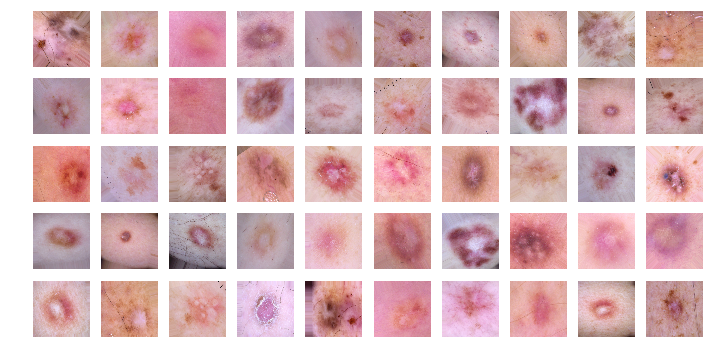

In [21]:
def plots(ims, figsize=(12,6), rows=5, interp=False, titles=None): # 12,6
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        
plots(imgs, titles=None) 

### Set Up the Generators

In [22]:
train_path = 'base_dir/train_dir'
valid_path = 'base_dir/val_dir'

num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)


In [23]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


# **CNN**

In [24]:
from keras.layers import Flatten,Dense,Dropout,BatchNormalization,Conv2D, MaxPool2D
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
from glob import glob

In [26]:
from keras.models import Sequential
import keras.models

In [27]:
input_shape = (224,224, 3)
num_classes = 7

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.16))

model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same'))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.20))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 112, 112, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 56, 56, 32)        0         
__________

In [28]:
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)


In [29]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [31]:
epochs = 30
batch_size = 10
history = model.fit_generator(train_batches, steps_per_epoch=train_steps,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=epochs, verbose=1,
                  callbacks=[learning_rate_reduction])


Epoch 1/30
908/908 [==============================] - 59s 65ms/step - loss: 1.5950 - acc: 0.3682 - val_loss: 0.8754 - val_acc: 0.7122
Epoch 2/30
908/908 [==============================] - 51s 56ms/step - loss: 1.3469 - acc: 0.4767 - val_loss: 0.6862 - val_acc: 0.7687
Epoch 3/30
908/908 [==============================] - 51s 57ms/step - loss: 1.2429 - acc: 0.5185 - val_loss: 0.6261 - val_acc: 0.7793
Epoch 4/30
908/908 [==============================] - 51s 57ms/step - loss: 1.1643 - acc: 0.5567 - val_loss: 0.6897 - val_acc: 0.7548
Epoch 5/30
908/908 [==============================] - 50s 55ms/step - loss: 1.1103 - acc: 0.5727 - val_loss: 0.6225 - val_acc: 0.7772
Epoch 6/30
908/908 [==============================] - 51s 56ms/step - loss: 1.0220 - acc: 0.6052 - val_loss: 0.5619 - val_acc: 0.7751
Epoch 7/30
908/908 [==============================] - 51s 56ms/step - loss: 1.0151 - acc: 0.6137 - val_loss: 0.5056 - val_acc: 0.8145
Epoch 8/30
908/908 [==============================] - 50s 55ms

In [32]:
from sklearn.metrics import classification_report,confusion_matrix

In [33]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [34]:
val_loss, val_cat_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)

model.save("model.h5")

val_loss: 0.48075364217932615
val_cat_acc: 0.8507462686567164


In [35]:
model.metrics_names

['loss', 'acc']

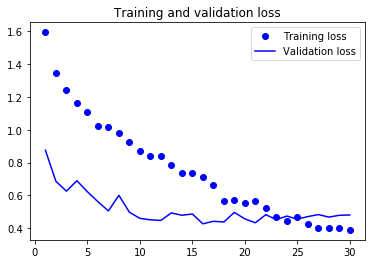

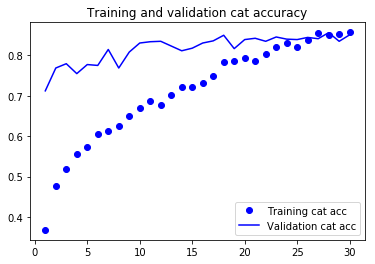

<Figure size 432x288 with 0 Axes>

In [36]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()



plt.show()



In [37]:
test_labels = test_batches.classes

In [38]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [39]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [40]:
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

938/938 [==============================] - 12s 12ms/step


In [41]:
predictions.shape

(938, 7)

In [42]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [43]:
test_labels.shape

(938,)

In [44]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [45]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 11   3   6   0   3   3   0]
 [  3  16   5   4   0   2   0]
 [  1   0  44   4   9  16   1]
 [  0   0   1   2   0   3   0]
 [  2   0   5   1  16  14   1]
 [  1   4  17   4  28 696   1]
 [  0   1   0   0   0   1   9]]


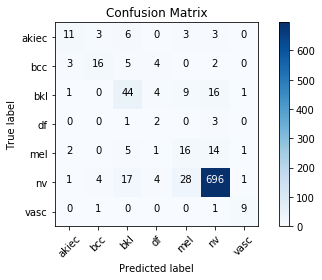

In [46]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [47]:
y_pred = np.argmax(predictions, axis=1)
y_true = test_batches.classes

In [48]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

             precision    recall  f1-score   support

      akiec       0.61      0.42      0.50        26
        bcc       0.67      0.53      0.59        30
        bkl       0.56      0.59      0.58        75
         df       0.13      0.33      0.19         6
        mel       0.29      0.41      0.34        39
         nv       0.95      0.93      0.94       751
       vasc       0.75      0.82      0.78        11

avg / total       0.86      0.85      0.85       938



# **MobileNet**

In [49]:
from numpy.random import seed
seed(101)
from tensorflow import set_random_seed
set_random_seed(101)

import pandas as pd
import numpy as np

import tensorflow
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

import os

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy
import matplotlib.pyplot as plt

In [50]:
datagen = ImageDataGenerator(
    preprocessing_function= \
    tensorflow.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 38569 images belonging to 7 classes.
Found 938 images belonging to 7 classes.
Found 938 images belonging to 7 classes.


### Modify MobileNet Model

In [51]:
mobile = tensorflow.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 0s 0us/step


In [52]:
mobile.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [53]:
type(mobile.layers)

list

In [54]:
len(mobile.layers)

93

In [55]:
x = mobile.layers[-6].output

x = Dropout(0.25)(x)
predictions = Dense(7, activation='softmax')(x)

model = Model(inputs=mobile.input, outputs=predictions)

In [56]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
__________

In [57]:
for layer in model.layers[:-23]:
    layer.trainable = False

### Train the Model

In [58]:
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [59]:
model.compile(Adam(lr=0.01), loss='categorical_crossentropy', 
              metrics=[categorical_accuracy, top_2_accuracy, top_3_accuracy])



In [60]:
print(valid_batches.class_indices)

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [61]:
class_weights={
    0: 1.0, # akiec
    1: 1.0, # bcc
    2: 1.0, # bkl
    3: 1.0, # df
    4: 3.0, # mel # Try to make the model more sensitive to Melanoma.
    5: 1.0, # nv
    6: 1.0, # vasc
}

In [62]:

filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_top_3_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.5, patience=2, 
                                   verbose=1, mode='max', min_lr=0.00001)
                              
                              
callbacks_list = [checkpoint, reduce_lr]

history = model.fit_generator(train_batches, steps_per_epoch=train_steps, 
                              class_weight=class_weights,
                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=30, verbose=1,
                   callbacks=callbacks_list)


Epoch 1/30
907/908 [============================>.] - ETA: 0s - loss: 1.3884 - categorical_accuracy: 0.5119 - top_2_accuracy: 0.7232 - top_3_accuracy: 0.8452
Epoch 00001: val_top_3_accuracy improved from -inf to 0.79318, saving model to model.h5
908/908 [==============================] - 58s 64ms/step - loss: 1.3874 - categorical_accuracy: 0.5121 - top_2_accuracy: 0.7233 - top_3_accuracy: 0.8454 - val_loss: 1.7158 - val_categorical_accuracy: 0.4009 - val_top_2_accuracy: 0.6258 - val_top_3_accuracy: 0.7932
Epoch 2/30
907/908 [============================>.] - ETA: 0s - loss: 0.9834 - categorical_accuracy: 0.6079 - top_2_accuracy: 0.8091 - top_3_accuracy: 0.9133
Epoch 00002: val_top_3_accuracy improved from 0.79318 to 0.91898, saving model to model.h5
908/908 [==============================] - 50s 55ms/step - loss: 0.9826 - categorical_accuracy: 0.6082 - top_2_accuracy: 0.8092 - top_3_accuracy: 0.9134 - val_loss: 0.8702 - val_categorical_accuracy: 0.7260 - val_top_2_accuracy: 0.8593 - va

### Evaluate the model using the val set

In [63]:
model.metrics_names

['loss', 'categorical_accuracy', 'top_2_accuracy', 'top_3_accuracy']

In [64]:
val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.8684576310404912
val_cat_acc: 0.7601279317697228
val_top_2_acc: 0.8955223880597015
val_top_3_acc: 0.9509594882729211


In [65]:
model.load_weights('model.h5')

val_loss, val_cat_acc, val_top_2_acc, val_top_3_acc = \
model.evaluate_generator(test_batches, 
                        steps=len(df_val))

print('val_loss:', val_loss)
print('val_cat_acc:', val_cat_acc)
print('val_top_2_acc:', val_top_2_acc)
print('val_top_3_acc:', val_top_3_acc)

val_loss: 0.587132240817163
val_cat_acc: 0.8123667377398721
val_top_2_acc: 0.9275053304904051
val_top_3_acc: 0.964818763326226


### Plot the Training Curves

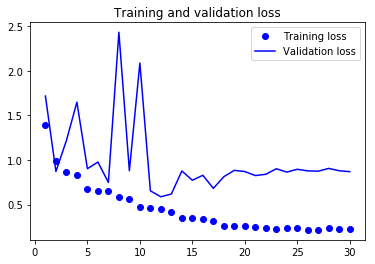

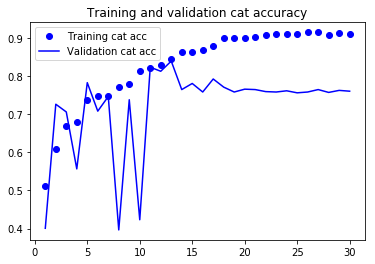

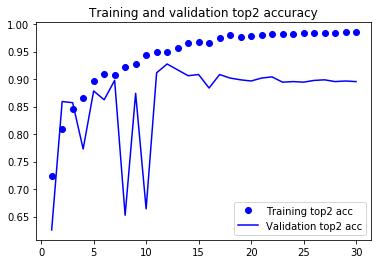

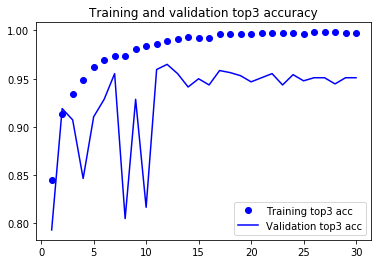

In [66]:
import matplotlib.pyplot as plt

acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
train_top2_acc = history.history['top_2_accuracy']
val_top2_acc = history.history['val_top_2_accuracy']
train_top3_acc = history.history['top_3_accuracy']
val_top3_acc = history.history['val_top_3_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'bo', label='Training cat acc')
plt.plot(epochs, val_acc, 'b', label='Validation cat acc')
plt.title('Training and validation cat accuracy')
plt.legend()
plt.figure()


plt.plot(epochs, train_top2_acc, 'bo', label='Training top2 acc')
plt.plot(epochs, val_top2_acc, 'b', label='Validation top2 acc')
plt.title('Training and validation top2 accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, train_top3_acc, 'bo', label='Training top3 acc')
plt.plot(epochs, val_top3_acc, 'b', label='Validation top3 acc')
plt.title('Training and validation top3 accuracy')
plt.legend()


plt.show()

### Create a Confusion Matrix

In [67]:
test_labels = test_batches.classes

In [68]:
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

In [69]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [70]:
predictions = model.predict_generator(test_batches, steps=len(df_val), verbose=1)

938/938 [==============================] - 13s 14ms/step


In [71]:
predictions.shape

(938, 7)

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()




In [73]:
test_labels.shape

(938,)

In [74]:
cm = confusion_matrix(test_labels, predictions.argmax(axis=1))

In [75]:
test_batches.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

Confusion matrix, without normalization
[[ 14   7   0   3   0   2   0]
 [  1  27   0   1   0   1   0]
 [ 18  10   8   2   5  32   0]
 [  0   0   0   3   0   3   0]
 [  3   6   0   1   7  21   1]
 [  4  21   0  25   5 695   1]
 [  0   0   0   0   0   3   8]]


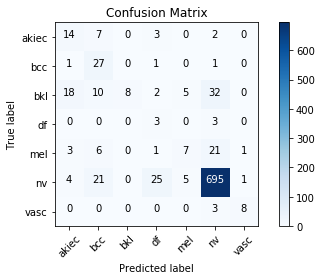

In [76]:
cm_plot_labels = ['akiec', 'bcc', 'bkl', 'df', 'mel','nv', 'vasc']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

### Generate the Classification Report

In [77]:
y_pred = np.argmax(predictions, axis=1)

y_true = test_batches.classes

In [78]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred, target_names=cm_plot_labels)

print(report)

             precision    recall  f1-score   support

      akiec       0.35      0.54      0.42        26
        bcc       0.38      0.90      0.53        30
        bkl       1.00      0.11      0.19        75
         df       0.09      0.50      0.15         6
        mel       0.41      0.18      0.25        39
         nv       0.92      0.93      0.92       751
       vasc       0.80      0.73      0.76        11

avg / total       0.86      0.81      0.80       938



In [79]:
model_json = model.to_json()
with open("model.json", "w") as j_file:
    j_file.write(model_json)

In [80]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model1.h5")
print("Saved model to disk")

Saved model to disk
